In [4]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [5]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [6]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [7]:
data = read_text("/home/azureuser/cloudfiles/code/Users/DANIEL.OBRIEN.2022/TR2EN.txt")
tr_eng = to_lines(data)
tr_eng = array(tr_eng)
tr_eng = tr_eng[:50000,:]

In [8]:
# Remove punctuation
tr_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in tr_eng[:,0]]
tr_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in tr_eng[:,1]]

tr_eng

array([['Hi', 'Merhaba'],
       ['Hi', 'Selam'],
       ['Run', 'Kaç'],
       ...,
       ['Do you have the key', 'Anahtarın var mı'],
       ['Do you have to stay', 'Kalmak zorunda mısın'],
       ['Do you keep a diary', 'Bir günlük tutuyor musunuz']],
      dtype='<U272')

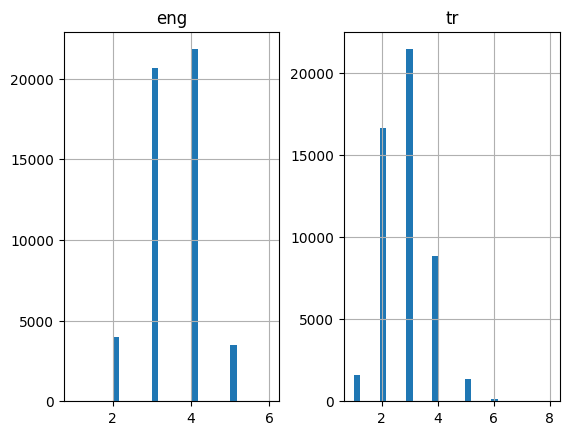

In [9]:
# empty lists
eng_l = []
tr_l = []

# populate the lists with sentence lengths
for i in tr_eng[:,0]:
      eng_l.append(len(i.split()))

for i in tr_eng[:,1]:
      tr_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'tr':tr_l})

length_df.hist(bins = 30)
plt.show()

In [10]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [11]:
# prepare english tokenizer
eng_tokenizer = tokenization(tr_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6623


In [12]:
# prepare turkish tokenizer
tr_tokenizer = tokenization(tr_eng[:, 1])
tr_vocab_size = len(tr_tokenizer.word_index) + 1

tr_length = 8
print('Turkish Vocabulary Size: %d' % tr_vocab_size)

Turkish Vocabulary Size: 18445


In [13]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [14]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(tr_eng, test_size=0.2, random_state = 12)

In [15]:
# prepare training data
trainX = encode_sequences(tr_tokenizer, tr_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(tr_tokenizer, tr_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [16]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [ ]:
# model compilation
model = define_model(tr_vocab_size, eng_vocab_size, tr_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [18]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=5, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/5
63/63 [==============================] - ETA: 0s - loss: 3.3481
Epoch 1: val_loss improved from inf to 2.72750, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets
63/63 [==============================] - 220s 3s/step - loss: 3.3481 - val_loss: 2.7275
Epoch 2/5
63/63 [==============================] - ETA: 0s - loss: 2.6152
Epoch 2: val_loss improved from 2.72750 to 2.59504, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets
63/63 [==============================] - 213s 3s/step - loss: 2.6152 - val_loss: 2.5950
Epoch 3/5
63/63 [==============================] - ETA: 0s - loss: 2.4786
Epoch 3: val_loss improved from 2.59504 to 2.45759, saving model to model.h1.24_jan_19
INFO:tensorflow:Asse

INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


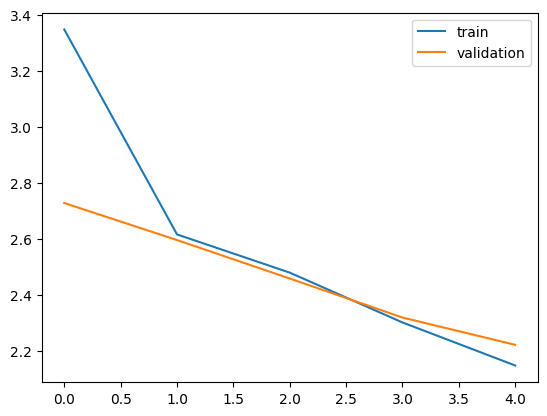

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [31]:
import numpy as np
model = load_model('model.h1.24_jan_19')
preds = model.predict(testX.reshape((testX.shape[0],testX.shape[1])))

2024-04-09 14:11:43.623952: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2024-04-09 14:11:43.640981: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2024-04-09 14:11:44.323657: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2024-04-09 14:11:45.956802: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2024-04-09 14:11:45.972850: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 5 outputs but the _output_sh

313/313 [==============================] - 30s 90ms/step


In [32]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [33]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], tr_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], tr_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t) 

    preds_text.append(' '.join(temp))

KeyboardInterrupt: 

In [29]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})
# print 15 rows randomly
pred_df.head(15)

ValueError: All arrays must be of the same length